<class 'numpy.ndarray'>
uint16
(427, 561)


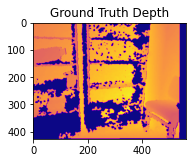

In [16]:
import scipy.io
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load metadata
mat = scipy.io.loadmat('C:/Project Deep Learning/data/SUNRGBD/kv1/b3dodata/img_0063/seg.mat')

# Load an example image & depth map
img_path = "C:/Project Deep Learning/data/SUNRGBD/kv1/b3dodata/img_0063/image/img_0063.jpg" 
depth_path = "C:/Project Deep Learning/data/SUNRGBD/kv1/b3dodata/img_0063/depth/img_0063_abs.png" 

# Read RGB image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read depth map
depth_gt = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

# Show both
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("RGB Image")

# plt.subplot(1, 2, 2)
# plt.imshow(depth_gt, cmap="plasma")
# plt.title("Ground Truth Depth")

print(type(depth_gt))  # Should be numpy.ndarray
print(depth_gt.dtype)  # Should be float32 or float64
print(depth_gt.shape)  # Should be (H, W), not a list of lists

plt.imshow(depth_gt, cmap="plasma")
plt.title("Ground Truth Depth")
plt.show()


plt.show()


In [19]:
def read_intrinsics(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
        # The intrinsic matrix is typically 3x3
        matrix = [list(map(float, line.split())) for line in lines]
    
    fx, fy = matrix[0][0], matrix[1][1]  # Focal lengths
    cx, cy = matrix[0][2], matrix[1][2]  # Principal point
    return fx, fy, cx, cy

# Load the intrinsic parameters
intrinsics_path = "C:/Project Deep Learning/data/SUNRGBD/kv1/b3dodata/img_0063/intrinsics.txt"
fx, fy, cx, cy = read_intrinsics(intrinsics_path)

print(f"Focal length fx: {fx}, fy: {fy}")
print(f"Principal point cx: {cx}, cy: {cy}")


Focal length fx: 520.532, fy: 520.7444
Principal point cx: 277.9258, cy: 215.115


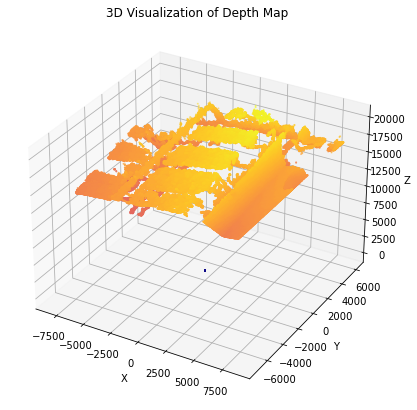

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# Create a meshgrid for pixel coordinates
height, width = depth_gt.shape
x, y = np.meshgrid(np.arange(width), np.arange(height))

# Flatten the arrays to work with each pixel
x = x.flatten()
y = y.flatten()
depth = depth_gt.flatten()

# Calculate the 3D coordinates
z = depth  # The depth is the z-coordinate
x_3d = (x - cx) * z / fx
y_3d = (y - cy) * z / fy

# Stack the 3D points into a (N, 3) array
points_3d = np.vstack((x_3d, y_3d, z)).T

# Visualize the 3D points
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter the points
ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c=z, cmap='plasma', s=1)

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Depth Map')

plt.show()


In [ ]:
import open3d as o3d

# Create Open3D point cloud from numpy array
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)

# Visualize point cloud
o3d.visualization.draw_geometries([pcd])


In [ ]:
# Compute the surface mesh using Poisson surface reconstruction
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh])


Using cache found in C:\Users\galin/.cache\torch\hub\isl-org_MiDaS_master


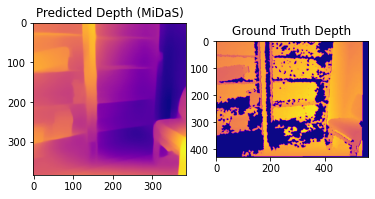

In [17]:
import torch
from torchvision import transforms

# Load MiDaS model
model = torch.hub.load("isl-org/MiDaS", "DPT_Large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# Preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def estimate_depth(img):
    img_resized = cv2.resize(img, (384, 384))
    input_tensor = transform(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        depth_map = model(input_tensor)

    return depth_map.squeeze().cpu().numpy()

# Run depth estimation
depth_pred = estimate_depth(image)

# Show results
plt.subplot(1, 2, 1)
plt.imshow(depth_pred, cmap="plasma")
plt.title("Predicted Depth (MiDaS)")

plt.subplot(1, 2, 2)
plt.imshow(depth_gt, cmap="plasma")
plt.title("Ground Truth Depth")

plt.show()


In [ ]:
import open3d as o3d
import numpy as np

# Example: Extract vertices and faces from JSON (adjust this to your specific data structure)
polygon = np.array(data["polygon"])  # Replace with actual key for vertices
# faces = np.array(data["faces"])  # Replace with actual key for faces

# Create a mesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(polygon)
# mesh.triangles = o3d.utility.Vector3iVector(faces)

# Visualize the mesh
o3d.visualization.draw_geometries([mesh])
